In [1]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import numpy as np


In [2]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        fields = next(csv_reader)

        # extracting each data row one by one
        for row in csv_reader:
            if row[1] == 'M':
                row[1] = '1'
            else:
                row[1] = '0'

            if row[8] == 'Y':
                row[8] = '1'
            else:
                row[8] = '0'

            input_row = []

            input_row.append(row[0])
            input_row.append(row[1])
            input_row.append(row[3])
            input_row.append(row[4])
            input_row.append(row[5])
            input_row.append(row[7])
            input_row.append(row[8])
            input_row.append(row[9])
            input_row.append(row[11])

            dataset.append(input_row)

    return dataset

In [3]:
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

        
        
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

In [4]:
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats



# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])


In [5]:
def activation(number):
    return 1.0 / (1.0 + exp(-number))

In [6]:
def initialise_network(n_inputs, n_hidden_layer, n_hidden, n_output):
    network = list()
    inputs = n_inputs
    for i in range(n_hidden_layer):
        hidden_layer = np.random.rand(inputs, n_hidden)
        hidden_layer = np.multiply(0.01, hidden_layer)
        network.append(hidden_layer)
        bias_hidden = np.random.rand(1, n_hidden)
        bias_hidden = np.multiply(0.01, bias_hidden)
        network.append(bias_hidden)
        inputs = n_hidden
    output_layer = np.random.rand(n_hidden, n_output)
    output_layer = np.multiply(0.01, output_layer)
    network.append(output_layer)
    bias_output = np.random.rand(1, n_output)
    bias_output = np.multiply(0.01, bias_output)
    network.append(bias_output)
    return network

In [7]:
def forward_propogation(network, row, output):
    inputs = row
    i = 0
    while i < len(network):
        inputs = np.array(inputs)
        weights = network[i]
        res = np.dot(inputs, weights)
        i = i + 1
        bias = network[i]
        res = np.add(res, bias)
        new_input = list()
        for x in np.nditer(res):
            ans = activation(x)
            new_input.append(ans)
        inputs = new_input
        output.append(inputs)
        i = i + 1
    return inputs

In [8]:
def sigmoid_derivative(y):
    return y*(1-y)



def backward_propogation(network, output, expected):
    expected = np.array(expected)
    delta_list = list()
    for i in reversed(range(len(output))):
        our_output = np.array(output[i])
        if i == len(output)-1:
            errors = np.subtract(expected, our_output)
            j = 2*i
        else:
            weights = network[j]
            delta = delta.T
            errors = np.dot(weights, delta)
            errors = errors.T
            j = j-2

        delta = list()
        for x, y in np.nditer([errors, our_output]):
            ans = x * sigmoid_derivative(y)
            delta.append(ans)
        delta = np.array(delta)
        delta_list.append(delta)
    delta_list.reverse()
    return delta_list

In [9]:
def update_weights_and_bias(network, delta_list, output, row, l_rate):
    j = 0
    inputs = row
    for i in range(len(network)):
        if i%2 == 0:                 #for weights updation
            weights = network[i]
            weight_change = list()
            if j != 0:
                inputs = output[j - 1]
            delta = delta_list[j]
            for x in delta:
                t = l_rate * x
                temp = list()
                for y in inputs:
                    ans = t * y
                    temp.append(ans)
                weight_change.append(temp)
            weight_change = np.array(weight_change)
            weight_change = weight_change.T
            new_weights = np.add(weights, weight_change)
            network[i] = new_weights
        else:                          #bias updation
            bias = network[i]
            delta = delta_list[j]
            bias_change = list()
            for x in delta:
                t = x * l_rate
                bias_change.append(t)
            bias_change = np.array(bias_change)
            new_bias = np.add(bias, bias_change)
            network[i] = new_bias
            j = j + 1


In [10]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split



# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def F1_metric(actual, predicted):

    tp = tn = fp = fn = 0
    for i in range(len(actual)):
        if predicted[i] == actual[i]:
            if predicted[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if actual[i] == 0:
                fp += 1
            else:
                fn += 1
    
    precision = float(tp/(tp+fp))
    recall = float(tp/(tp+fn))

    f1_score = float(2*precision*recall/(precision+recall)) * 100

    return f1_score

In [11]:
 #Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            output = list()
            input_row = row[:len(row)-1]
            results = forward_propogation(network, input_row, output)
            expected = [0 for i in range(n_outputs)]
            expected[0] = row[-1]
            delta = backward_propogation(network, output, expected)
            update_weights_and_bias(network, delta, output, input_row, l_rate)


# Make a prediction with a network
def predict(network, row):
    results = list()
    input_row = row[:len(row)-1]
    outputs = forward_propogation(network, input_row, results)
    x = outputs[0]
    ret_val = round(x)            #Thresholding
    return ret_val

In [12]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def algorithm(train, test, num, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = 1
    network = initialise_network(n_inputs, 1, n_hidden, n_outputs)
    print(f" Training Started for {num} fold........")
    train_network(network, train, l_rate, n_epoch, n_outputs)
    print(f" Training Completed ")
    predictions = list()
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

In [13]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    f1_scores = list()
    num = 0
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        num = num + 1
        predicted = algorithm(train_set, test_set,num, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        f1_score = F1_metric(actual, predicted)
        f1_scores.append(f1_score)
    return scores, f1_scores

In [14]:
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'heart.csv'

dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)

    
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)


# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 15


scores, f1_scores = evaluate_algorithm(dataset, algorithm, n_folds, l_rate, n_epoch, n_hidden)

print("--------------- Accuracy Summary-----------------")

print()

for i in range(len(scores)):
    
    print(f"Accuracy Score for {i+1} fold :: {scores[i]}")

print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

print('Min Accuracy: %.3f%%' % (min(scores)))

print('Max Accuracy: %.3f%%' % (max(scores)))

print()

print("--------------------------------------------------")

print()

print("--------------- F1 Score Summary-----------------")

print()

for i in range(len(f1_scores)):
    
    print(f"F1 Score for {i+1} fold :: {f1_scores[i]}")

print('Mean F1 Score: %.3f%%' % (sum(f1_scores)/float(len(f1_scores))))

print('Min F1 Score: %.3f%%' % (min(f1_scores)))

print('Max F1 Score: %.3f%%' % (max(f1_scores)))

print()

print("--------------------------------------------------")


 Training Started for 1 fold........
 Training Completed 
 Training Started for 2 fold........
 Training Completed 
 Training Started for 3 fold........
 Training Completed 
 Training Started for 4 fold........
 Training Completed 
 Training Started for 5 fold........
 Training Completed 
--------------- Accuracy Summary-----------------

Accuracy Score for 1 fold :: 80.32786885245902
Accuracy Score for 2 fold :: 82.5136612021858
Accuracy Score for 3 fold :: 75.40983606557377
Accuracy Score for 4 fold :: 84.69945355191257
Accuracy Score for 5 fold :: 79.23497267759562
Mean Accuracy: 80.437%
Min Accuracy: 75.410%
Max Accuracy: 84.699%

--------------------------------------------------

--------------- F1 Score Summary-----------------

F1 Score for 1 fold :: 80.43478260869564
F1 Score for 2 fold :: 83.33333333333333
F1 Score for 3 fold :: 79.45205479452055
F1 Score for 4 fold :: 86.27450980392156
F1 Score for 5 fold :: 81.37254901960785
Mean F1 Score: 82.173%
Min F1 Score: 79.452%
Max 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
df = pd.read_csv("heart.csv")

In [17]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [18]:
df.drop(['ChestPainType','RestingECG','ST_Slope'],inplace=True,axis=1)

In [19]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
0,40,M,140,289,0,172,N,0.0,0
1,49,F,160,180,0,156,N,1.0,1
2,37,M,130,283,0,98,N,0.0,0
3,48,F,138,214,0,108,Y,1.5,1
4,54,M,150,195,0,122,N,0.0,0


In [20]:
temp = {"M" : 0 , "F" : 1}
df['Sex'] = df['Sex'].map(temp)

In [21]:
temp = {"N" : 0 , "Y" : 1}
df['ExerciseAngina'] = df['ExerciseAngina'].map(temp)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   RestingBP       918 non-null    int64  
 3   Cholesterol     918 non-null    int64  
 4   FastingBS       918 non-null    int64  
 5   MaxHR           918 non-null    int64  
 6   ExerciseAngina  918 non-null    int64  
 7   Oldpeak         918 non-null    float64
 8   HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 64.7 KB


In [23]:
df.isnull().sum()

Age               0
Sex               0
RestingBP         0
Cholesterol       0
FastingBS         0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
HeartDisease      0
dtype: int64

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
Y = df['HeartDisease']

In [26]:
type(Y)

pandas.core.series.Series

In [27]:
df.drop('HeartDisease', axis=1,inplace = True)

In [28]:
Y = np.int64(Y)

In [29]:
X = df

In [30]:
X_train , X_test , y_train , y_test = train_test_split(X , Y ,test_size= 0.3 , random_state=42)

In [31]:
X_train

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak
712,58,0,100,234,0,156,0,0.1
477,61,0,110,0,1,108,1,2.0
409,53,0,160,0,1,122,1,0.0
448,63,0,160,230,1,105,1,1.0
838,63,0,130,330,1,132,1,1.8
...,...,...,...,...,...,...,...,...
106,48,1,120,254,0,110,0,0.0
270,45,0,120,225,0,140,0,0.0
860,60,0,130,253,0,144,1,1.4
435,60,0,152,0,0,118,1,0.0


In [32]:
#KNN Algorithm:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(n_neighbors=5)

In [34]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [35]:
pred = knn.predict(X_test)

In [36]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss

In [37]:
print(confusion_matrix(y_test,pred))

[[ 76  36]
 [ 42 122]]


In [38]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       112
           1       0.77      0.74      0.76       164

    accuracy                           0.72       276
   macro avg       0.71      0.71      0.71       276
weighted avg       0.72      0.72      0.72       276



In [39]:
error_rate = []

for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

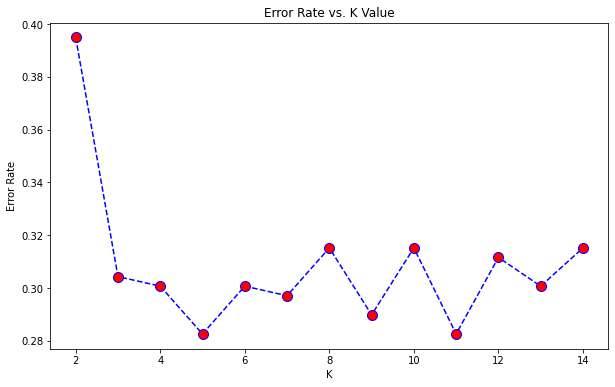

In [40]:
plt.figure(figsize=(10,6))
plt.plot(range(2,15),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [41]:
#Decision tree

In [42]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak
0,40,0,140,289,0,172,0,0.0
1,49,1,160,180,0,156,0,1.0
2,37,0,130,283,0,98,0,0.0
3,48,1,138,214,0,108,1,1.5
4,54,0,150,195,0,122,0,0.0


In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
dtc = DecisionTreeClassifier()

In [45]:
dtc.fit(X_train , y_train)

DecisionTreeClassifier()

In [46]:
pred_dtc = dtc.predict(X_test)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
print(classification_report(y_test , pred_dtc))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       112
           1       0.77      0.72      0.74       164

    accuracy                           0.70       276
   macro avg       0.69      0.70      0.70       276
weighted avg       0.71      0.70      0.70       276



In [49]:
print(confusion_matrix(y_test , pred_dtc))

[[ 76  36]
 [ 46 118]]


In [50]:
#implement SVm

In [51]:
from sklearn.svm import SVC

In [52]:
m_svm = SVC(kernel = 'linear')

In [53]:
m_svm.fit(X_train , y_train)

SVC(kernel='linear')

In [54]:
pred_svm = m_svm.predict(X_test)

In [55]:
print(classification_report(y_test , pred_svm))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       112
           1       0.87      0.80      0.84       164

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.82      0.82      0.82       276



In [56]:
print(confusion_matrix(y_test , pred_svm))

[[ 93  19]
 [ 32 132]]
